In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
device= "cuda:0"


def alpha(i, R, tau):
    return 1-torch.exp(-(R/tau)*i)

def action(state, R0, tau, Amat):
    deltaSIR= torch.zeros_like(state)
    deltaSIR[0]= -state[0]*torch.matmul(Amat, alpha(state[1], R0, tau))
    deltaSIR[2]= state[1]/tau
    deltaSIR[1]= -deltaSIR[0]-deltaSIR[2]
    return state+deltaSIR, -deltaSIR[0]
def one_strain(R0, tau0, timeHorizon, nodeNum,  Amat, time=0, fromS= 0):
    deltaSs= [torch.zeros(nodeNum, dtype=torch.float32, device=device)]
    nodeNum= Amat.shape[0]
    stateNowS= torch.ones(nodeNum, dtype=torch.float32, device=device)
    stateNowI= torch.zeros(nodeNum, dtype=torch.float32, device=device)
    stateNowR= torch.zeros(nodeNum, dtype=torch.float32, device=device)
    stateNow= torch.stack([stateNowS, stateNowI, stateNowR])
    noise= torch.randn((timeHorizon+1), dtype= torch.float32, device=device)/400
    for i in range(timeHorizon):
        stateNow, deltaS= action(stateNow, R0, tau0, Amat)
        if i==time:
            stateNow[0, fromS]= 0.99
            stateNow[1, fromS]= 0.01
            deltaS[fromS]= 0.01
        deltaSs.append(deltaS.clone())
    deltaSs= torch.stack(deltaSs)#+noise[:, None]
    return deltaSs
nodeNum= 50
Amat= torch.abs(torch.randn((nodeNum, nodeNum), dtype= torch.float32, device=device)/100)


In [878]:
strains= 4
timeHorizon= strains*20
R0s=   [8.37, 8, 6, 8.37, 8]
tau0s= [6.2, 7.5, 7.2, 7.5, 6.2]
for i in range(nodeNum):
    Amat[i, i]= 1
deltaSsList= []
deltaSsList.append(one_strain(R0s[0], tau0s[0], timeHorizon, nodeNum, Amat, time= 0, fromS= 0))
deltaSsList.append(one_strain(R0s[1], tau0s[1], timeHorizon, nodeNum, Amat, time= 20, fromS= 3))
deltaSsList.append(one_strain(R0s[2], tau0s[2], timeHorizon, nodeNum, Amat, time= 40, fromS= 1))
deltaSsList.append(one_strain(R0s[3], tau0s[3], timeHorizon, nodeNum, Amat, time= 60, fromS= 2))
deltaSsList.append(one_strain(R0s[4], tau0s[4], timeHorizon, nodeNum, Amat, time= 80, fromS= 7))
deltaSs= deltaSsList[0]
for i in range(strains- 1):
    deltaSs+= deltaSsList[i+1]
# deltaSs= torch.cat((deltaSs, deltaSs, deltaSs, deltaSs, deltaSs, deltaSs, deltaSs))
indice = torch.arange(deltaSs.shape[0], dtype= torch.float32, device=device).unsqueeze(0)/deltaSs.shape[0]
indices= torch.cat(nodeNum*[indice])
idx= torch.arange(1, 1+nodeNum, dtype= torch.float32, device=device)/nodeNum
idxs= torch.cat((timeHorizon+1)*[idx[None, :]])

embedded_tensor = torch.stack([indices, idxs.T, deltaSs.T], dim= -1)
#embedded_tensor= embedded_tensor.T
print(embedded_tensor.shape)
# print(embedded_tensor.shape)

torch.Size([50, 81, 3])


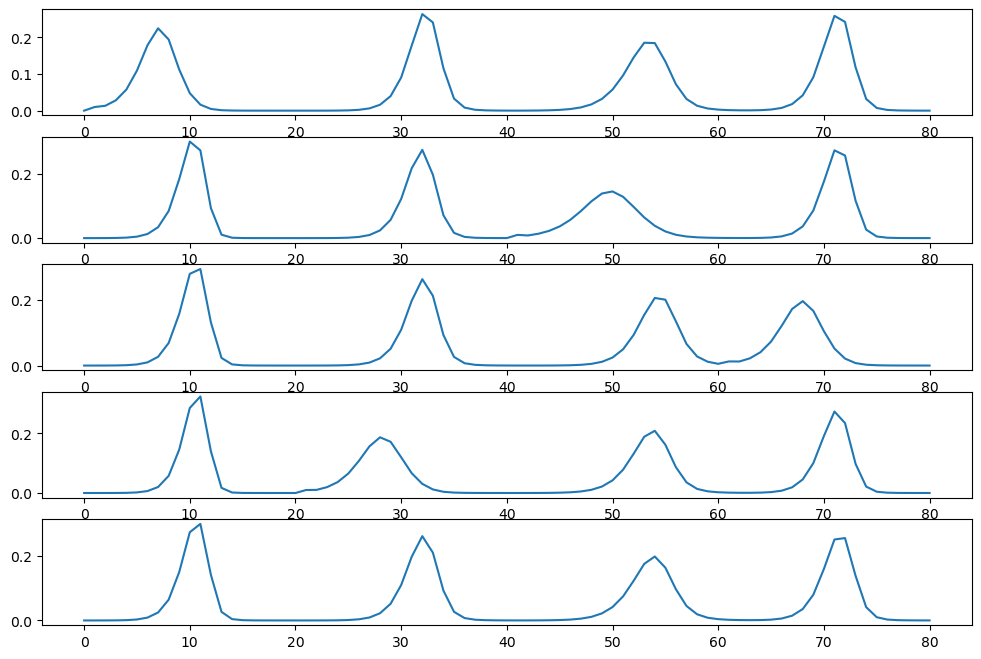

In [879]:
fig, axs = plt.subplots(5, 1, figsize=(12, 8))
for i, ax in enumerate(axs):
    ax.plot(embedded_tensor[i, :, -1].T.cpu().detach())

In [772]:

class MultiHeadAttention(torch.nn.Module):
    def __init__(self, input_dim= (21, 2), num_heads= 2, atten_dim= 1, device= "cpu"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads= num_heads
        self.input_dim= input_dim
        self.atten_dim= atten_dim
        # Linear transformations for queries, keys, and values
        self.W_q= torch.nn.Linear(input_dim[1], num_heads* input_dim[1], device= device)
        self.W_k= torch.nn.Linear(input_dim[1], num_heads* input_dim[0]*input_dim[1], device= device)
        self.W_v= torch.nn.Linear(input_dim[0], num_heads* input_dim[0], device= device)
        self.myAct= torch.nn.Softmax(dim= 2)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate scaled dot product attention
        attention_scores = torch.matmul(Q, K)
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))

        attention_weights = F.softmax(attention_scores, dim=-1)
        output = torch.matmul(attention_weights, V)
        return output.squeeze(dim=-1)

    def forward(self, x, mask=None):
        # Linear transformations
        Q = self.W_q(x).view(x.shape[0], x.shape[1], self.num_heads, 1, x.shape[2])
        K = self.W_k(x).view(x.shape[0], x.shape[1], self.num_heads, x.shape[2], x.shape[1])
        V = self.W_v(x[:, :, self.atten_dim]).view(x.shape[0], 1, self.num_heads, x.shape[1], 1)
        # Apply attention
        attention_output = self.scaled_dot_product_attention(Q, K, V, mask)
        return self.myAct(attention_output)

In [773]:
class Epis(torch.nn.Module):
    def __init__(self, input_dim= 20, num_heads= 1, num_nodes= 1, device= "cpu"):
        super(Epis, self).__init__()
        self.device= device
        self.num_heads= num_heads
        self.num_nodes= num_nodes
        self.taus= torch.ones((num_nodes, num_heads), dtype= torch.float32, device=device)*5
        self.taus= torch.nn.Parameter(self.taus)
        self.R0dTaus= torch.ones((num_nodes, num_heads), dtype= torch.float32, device=device)*2
        self.R0dTaus= torch.nn.Parameter(self.R0dTaus)
        self.Amat= torch.randn((num_nodes, num_nodes), dtype= torch.float32, device=device)- 2
        self.AmatMask= 1- torch.eye(num_nodes, dtype= torch.float32, device=device)
        self.Amateye= torch.eye(num_nodes, dtype= torch.float32, device=device)
        self.Amat= torch.nn.Parameter(self.Amat)
        self.mat, self.mask= self.create_temporal_mat(input_dim)
        self.myRelu= torch.nn.ReLU()
        self.mySig= torch.nn.Sigmoid()
        self.mySoft= torch.nn.Softmax(dim=2)

    def alpha(self, i, R0, tau):
        return 1-torch.exp(-(R0/tau)*i)
    
    def create_temporal_mat(self, lang):
        mat= torch.zeros((lang, lang), dtype= torch.float32, device= self.device)
        mask= torch.zeros((lang, lang), dtype= torch.float32, device= device)
        for i in range(lang):
            for j in range(i+1):
                mat[i, j]= i- j 
                mask[i, j]= 1
        return mat[None, None, ...], mask[None, None, ...]

    def forward(self, x, Amat= None): # shape: (1, 2, 20), dim of nodes, dim of heads, dim of signal
        # divide= self.mySoft(self.output)*x[:, :, -1:]#(1, 2, 20), dim of nodes, dim of heads, dim of signal
        # divide= divide.transpose(1, 2)
        if Amat==None:
            tempAmat= self.mySig(self.Amat)*self.AmatMask+ self.Amateye
        else:
            tempAmat= Amat
        noise= x[:, 0, :] #\noise delta S
        signal= self.myRelu(x[:, 1:, :]) #\delta S
        Ss= 1- torch.cumsum(signal, dim= -1) #easiy negative
        IsMat= torch.exp(self.mat*torch.log(1-1/self.taus[... , None, None]))*self.mask
        Is= torch.matmul(IsMat, signal[..., None]).squeeze(dim=-1)
        alpha= (1-torch.exp(-self.R0dTaus[... , None]*Is))
        temp= tempAmat[..., None, None]*alpha[:, None, ...]
        Alpha= temp.sum(dim= 0)
        predSignal= Alpha*Ss
        #signalPredict= self.alpha(Is[0: -1], R0, tau)*Ss[0:-1] 
        return predSignal, signal, tempAmat, noise

In [880]:
att= MultiHeadAttention(input_dim= (timeHorizon+1, 3), num_heads= strains+1, atten_dim= 2, device= device)
myEpi=Epis(input_dim= timeHorizon+1, num_heads= strains, num_nodes= nodeNum, device= device)
optimizer = torch.optim.Adam(att.parameters(), lr=2e-4)
#optimizer2 = torch.optim.Adam([{"params": myEpi.parameters(), "lr": 1e-3}])
optimizer2 = torch.optim.Adam({myEpi.taus},lr=2e-4)
optimizer3 = torch.optim.Adam({myEpi.Amat},lr=2e-4)
optimizer4 = torch.optim.Adam({myEpi.R0dTaus},lr=2e-4)
myloss= torch.nn.MSELoss(reduction='sum')
losses= []

In [890]:
for j in tqdm(range(10000)):
    optimizer.zero_grad()
    optimizer2.zero_grad()
    optimizer3.zero_grad()
    optimizer4.zero_grad()
    output= att(embedded_tensor).squeeze(dim= -1)
    divide= output*embedded_tensor[:, :, -1:]#(1, 2, 20), dim of nodes, dim of heads, dim of signal
    divide= divide.transpose(1, 2)
    predSignal, signal, tempAmat, noise= myEpi(divide)
    loss= myloss(predSignal[:, :, 0:-1], signal[:, :, 1:])*10+ torch.var(myEpi.taus, dim= 0).sum()\
        + torch.var(myEpi.R0dTaus, dim= 0).sum()+ torch.abs(noise.sum())
    losses.append(loss.item())
    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer2.step()
    optimizer3.step()
    optimizer4.step()
print(loss/strains)#0.0010, 0.0008, 0.0007, 0.0006
#print(divide.T)
#print(tau)
#print(R0)

100%|██████████| 10000/10000 [01:05<00:00, 153.12it/s]

tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>)


In [891]:

print(myEpi.taus[0])
print((myEpi.taus*myEpi.R0dTaus)[0])
print("delta sum:", torch.abs(tempAmat-Amat).sum())#0.0934, 0.1221, 0.1428
print(torch.var(myEpi.taus, dim= 0))
print(torch.var(myEpi.R0dTaus, dim= 0))
print(torch.sum(predSignal[0, :, 0:-1])/strains)
print(torch.sum(signal[0, :, 1:])/strains)
#matA1= tempAmat.clone()
#matA2= tempAmat.clone()
#matA3= tempAmat.clone()
matA4= tempAmat.clone()
#print(tempAmat)
#R0= 8.37, 6.2
#tau0= 7.5R0s=   [8.37, 8, 6, 8.37, 8]
#       tau0s= [6.2, 7.5, 7.2, 7.5, 6.2]
exper=[18.081, 19.4092, 19.8419, 18.6318]
exper2=[0.6408, 11.67, 14.89, 11.56, 12.57]


tensor([7.0105, 7.3290, 7.2403, 5.9478], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([5.8878, 8.2244, 7.7859, 8.0687], device='cuda:0',
       grad_fn=<SelectBackward0>)
delta sum: tensor(18.6318, device='cuda:0', grad_fn=<SumBackward0>)
tensor([4.3830e-09, 1.0972e-09, 4.7635e-10, 1.2670e-09], device='cuda:0',
       grad_fn=<VarBackward0>)
tensor([1.1484e-06, 5.5788e-07, 7.4507e-07, 1.2310e-06], device='cuda:0',
       grad_fn=<VarBackward0>)
tensor(0.9976, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9999, device='cuda:0', grad_fn=<DivBackward0>)


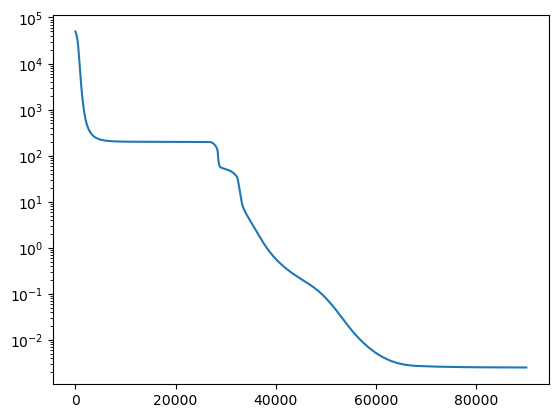

In [892]:
plt.plot(losses)
plt.yscale("log")

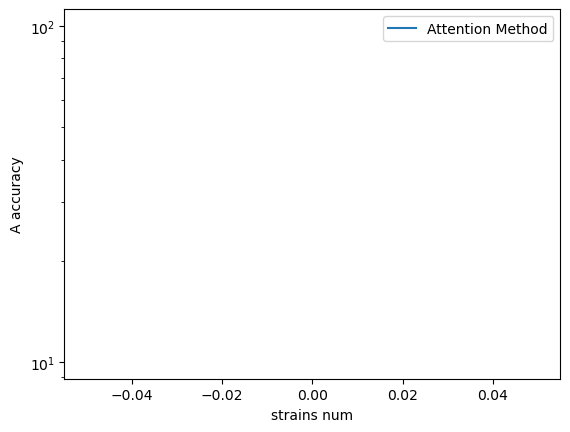

In [768]:
plt.plot(exper, label= "Attention Method")
#plt.plot(exper2, label= "Direct Method")
plt.xlabel("strains num")
plt.ylabel("A accuracy")
plt.yscale("log")
plt.legend()


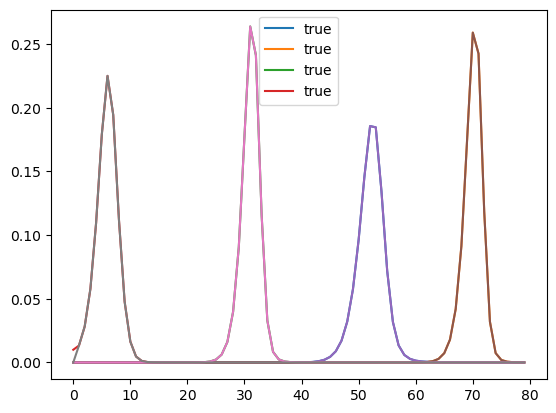

In [893]:
plt.plot(signal[0, :, 1:].squeeze().T.cpu().detach(), label=strains*["true"])
#plt.plot(embedded_tensor[0, :, -1:].squeeze().T.cpu().detach())
plt.plot(predSignal[0, :, 0:-1].squeeze().T.cpu().detach())
#plt.plot(noise[0].T.cpu().detach())
plt.legend()

In [54]:
print(predSignal)

tensor([[[ 2.8981e-04,  6.5643e-04,  1.1764e-03,  ..., -4.8123e-06,
          -2.5756e-06, -1.3793e-06],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.7367e-04,  3.9734e-04,  7.1843e-04,  ..., -0.0000e+00,
          -0.0000e+00, -0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.2435e-02,  2.8584e-02,  5.2121e-02,  ..., -0.0000e+00,
          -0.0000e+00, -0.0000e+00],
         [ 2.1886e-03,  2.1981e-03,  1.6178e-03,  ...,  4.9977e-07,
           2.6761e-07,  1.4305e-07]]], grad_fn=<MulBackward0>)
